# Make drizzled tiles

There are functionality for defining a tiling grid for a particular field and functions on EC2 to drizzle the tiles in parallel.

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

import astropy.time

from grizli.aws import db
from grizli import utils

Set ROOT_PATH=/usr/local/share/python/panoramic-jwst/Notebooks


In [3]:
if os.path.exists('/workspaces/panoramic-jwst/Mosaics'):
    os.chdir('/workspaces/panoramic-jwst/Mosaics')

os.getcwd()

'/usr/local/share/python/panoramic-jwst/Notebooks'

In [13]:
# Query for tiles

runmode = 'panoramic'
# runmode = 'uncover'
#runmode = 'smacs'
# runmode = 'gds'
# runmode = 'spitzer_idf'

# runmode = 'egs-v2'

# runmode = 'cos'
# runmode = 'uds'
# runmode = 'j013804m2156'
# runmode = 'macs0416'
# runmode = 'sextansa'
# runmode = 'j031124m5823'

# Find everything back to the beginning of Cycle 1
lookback_time = 800

# runmode = 'abell370'

if runmode == 'panoramic':
    # PANORAMIC
    fields = "AND (field like 'panoramic%%' OR field = 'j013804m2156')"
    prog = "AND (e.dataset like 'jw02514%%' OR e.dataset like 'jw06549%%')"

    # Limit to more recent so that it runs faster
    lookback_time = 20
    
elif runmode == 'spitzer_idf':
    # PANORAMIC
    fields = "AND field = 'spitzer_idf'"
    prog = "AND (e.dataset like 'jw02738%%')"

elif runmode == 'egs-v2':
    # PANORAMIC
    fields = "AND field = 'egs-v2'"
    prog = "AND (e.dataset like 'jw01345%%' OR e.dataset like 'jw02279%%' OR e.dataset like 'jw02514%%' OR e.dataset like 'jw02750%%')"

elif runmode == 'uncover':
    # PANORAMIC
    fields = "AND field = 'abell2744'"
    prog = "AND (e.dataset like 'jw01324%%' OR e.dataset like 'jw02561%%' OR e.dataset like 'jw03516%%' OR e.dataset like 'jw02756%%' OR e.dataset like 'jw04111%%')"
    
elif runmode == 'smacs':
    # SMACS 0723
    fields = "AND field = 'j072305m7327'"
    prog = "AND (e.dataset like 'jw02736%%')"
    
elif runmode == 'panoramic-uds':
    # Extra UDS
    fields = "AND field = 'uds'"
    prog = "AND e.dataset like 'jw02514%%'"
    
elif runmode == 'macs0416':
    # Extra UDS
    fields = "AND field = 'macs0416'"
    prog = "AND (e.dataset like 'jw02514%%' OR e.dataset like 'jw01208%%' OR e.dataset like 'jw01176%%')"
    
elif runmode == 'gds':
    # GOODS-South
    fields = "AND field = 'gds'"
    prog = "AND (e.dataset like 'jw01895%%' OR e.dataset like 'jw01180%%' OR e.dataset like 'jw02514%%' OR e.dataset like 'jw03215%%')"
    prog = "AND (e.dataset like 'jw01283%%')"
    prog = "AND (e.dataset like 'jw02198%%')"
    prog = """AND (e.dataset like 'jw01895%%' OR e.dataset like 'jw01180%%' OR e.dataset like 'jw02514%%'
                   OR e.dataset like 'jw03215%%' or e.dataset like 'jw02198%%' or e.dataset like 'jw01283%%'
                   or e.dataset like 'jw02079%%' or e.dataset like 'jw01207%%')"""
    
elif runmode == 'cos':
    fields = "AND field = 'cos'"
    # Valentino
    prog = "AND (e.dataset like 'jw03567%%' OR e.dataset like 'jw01635%%')"
    prog = "AND (e.dataset like 'jw01727%%' OR e.dataset like 'jw02514%%' or e.dataset like 'jw03990%%')"
    
elif runmode == 'abell370':
    fields = "AND field = 'abell370'"
    # Valentino
    prog = "AND (e.dataset like 'jw01208%%' OR e.dataset like 'jw02514%%' OR e.dataset like 'jw03538%%' OR e.dataset like 'jw03362%%')"
elif runmode == 'uds':
    fields = "AND field = 'uds'"
    # Valentino
    prog = "AND (e.dataset like 'jw03567%%' OR e.dataset like 'jw01635%%')"
elif runmode == 'j013804m2156':
    fields = "AND field = 'j013804m2156'"
    prog = "AND (e.dataset like 'jw06549%%' OR e.dataset like 'jw02514%%')"
else:
    fields = f"AND field = '{runmode}'"
    # prog = "AND (e.dataset like 'jw01791%%')" # j0311

    
instruments = "'NIRCAM','MIRI','NIRISS'"

filters = "'F090W-CLEAR','F115W-CLEAR','F150W-CLEAR','F200W-CLEAR'"
filters += ",'F182M-CLEAR','F210M-CLEAR'"
# filters += ",'F070W-CLEAR','F140M-CLEAR','F300M-CLEAR','F250M-CLEAR','F335M-CLEAR','F360M-CLEAR'"
filters += ",'F070W-CLEAR','F140M-CLEAR','F300M-CLEAR','F250M-CLEAR','F335M-CLEAR','F360M-CLEAR'"
filters += ",'F277W-CLEAR','F356W-CLEAR','F410M-CLEAR','F444W-CLEAR'"
filters += ",'F560W','F770W','F1800W','CLEARP-F444W'"
filters += ",'F430M-CLEAR','F460M-CLEAR'"
filters += ",'F090WN-CLEAR','CLEARP-F277W','CLEARP-F356W'"
filters += ",'F150W2-CLEAR'"

# instruments = "'NIRISS'"

# filters = "'F410M-CLEAR'"

print(f'# lookback_time: {lookback_time} days')

QUERY = f"""SELECT file, assoc, instrume, filter, tile, field, e.footprint, t.footprint as tile_footprint
FROM exposure_files e, combined_tiles t
WHERE instrume in ({instruments})
{fields}
AND polygon(e.footprint) && polygon(t.footprint)
{prog} AND e.filter in ({filters})
AND expstart > {astropy.time.Time.now().mjd - lookback_time}
"""

print(QUERY)

res = db.SQL(QUERY)


len(res)

# lookback_time: 20 days
SELECT file, assoc, instrume, filter, tile, field, e.footprint, t.footprint as tile_footprint
FROM exposure_files e, combined_tiles t
WHERE instrume in ('NIRCAM','MIRI','NIRISS')
AND (field like 'panoramic%%' OR field = 'j013804m2156')
AND polygon(e.footprint) && polygon(t.footprint)
AND (e.dataset like 'jw02514%%' OR e.dataset like 'jw06549%%') AND e.filter in ('F090W-CLEAR','F115W-CLEAR','F150W-CLEAR','F200W-CLEAR','F182M-CLEAR','F210M-CLEAR','F070W-CLEAR','F140M-CLEAR','F300M-CLEAR','F250M-CLEAR','F335M-CLEAR','F360M-CLEAR','F277W-CLEAR','F356W-CLEAR','F410M-CLEAR','F444W-CLEAR','F560W','F770W','F1800W','CLEARP-F444W','F430M-CLEAR','F460M-CLEAR','F090WN-CLEAR','CLEARP-F277W','CLEARP-F356W','F150W2-CLEAR')
AND expstart > 60301.50086706586



524

In [14]:
instruments = ','.join([f"'{f}'" for f in np.unique(res['instrume']).tolist()])
filters = ','.join([f"'{f}'" for f in np.unique(res['filter']).tolist()])

filters, instruments

("'F115W-CLEAR','F150W-CLEAR','F200W-CLEAR','F277W-CLEAR','F356W-CLEAR','F410M-CLEAR','F444W-CLEAR'",
 "'NIRCAM'")

In [20]:
# Query counting by exposures per field
# can take a while

fields = ','.join([f"'{f}'" for f in np.unique(res['field']).tolist()])
tiles = ','.join([f"'{f}'" for f in np.unique(res['tile']).tolist()])
instruments = ','.join([f"'{f}'" for f in np.unique(res['instrume']).tolist()])
filters = ','.join([f"'{f}'" for f in np.unique(res['filter']).tolist()])
prog = ''

grp = db.SQL(f"""select field, tile, instrume, filter, count(filter) as ndrizim
from exposure_files e, combined_tiles t
where instrume in ({instruments})
AND t.field in ({fields})
AND t.tile in ({tiles})
AND polygon(e.footprint) && polygon(t.footprint)
{prog}
AND e.filter in ({filters})
group by field, tile, instrume, filter
order by field, tile, instrume, filter
""")
grp

field,tile,instrume,filter,ndrizim
str12,str5,str6,str11,int64
j013804m2156,07.08,NIRCAM,F115W-CLEAR,25
j013804m2156,07.08,NIRCAM,F150W-CLEAR,25
j013804m2156,07.08,NIRCAM,F200W-CLEAR,25
j013804m2156,07.08,NIRCAM,F277W-CLEAR,12
j013804m2156,07.08,NIRCAM,F356W-CLEAR,12
j013804m2156,07.08,NIRCAM,F444W-CLEAR,12
j013804m2156,08.07,NIRCAM,F115W-CLEAR,14
...,...,...,...,...
j013804m2156,10.10,NIRCAM,F115W-CLEAR,28


In [21]:
utils.Unique(grp['filter'])

   N  value     
====  ==========
   7  F410M-CLEAR
   9  F200W-CLEAR
   9  F277W-CLEAR
   9  F356W-CLEAR
  10  F444W-CLEAR
  11  F115W-CLEAR
  11  F150W-CLEAR


   N  value     
====  ==========
 524  j013804m2156


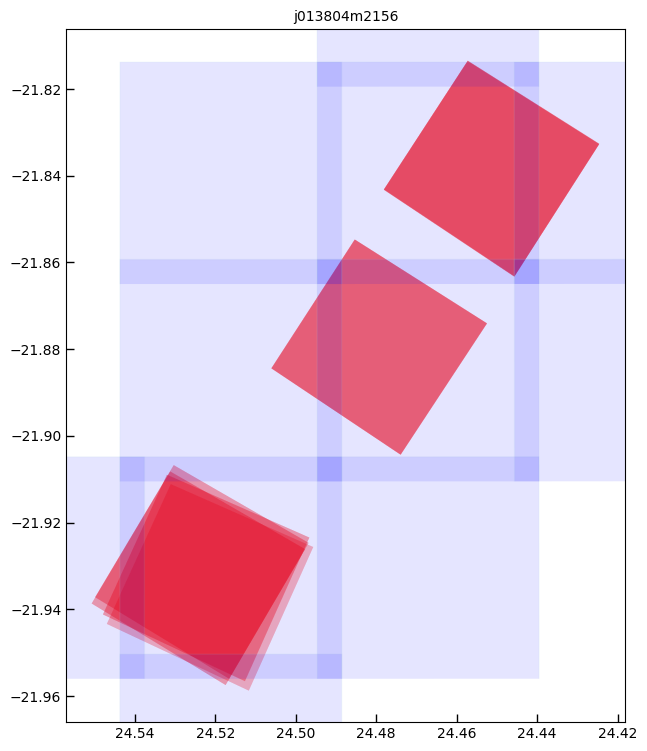

In [22]:
# Make field plots

un = utils.Unique(res['field'])

figs = {}

for v in un.values:
    fig, ax = plt.subplots(1,1,figsize=(9,9))
    test = un[v] & np.in1d(res['filter'], ['F444W-CLEAR'])
    jw_color = 'r'

    if test.sum() == 0:
        test = un[v] & np.in1d(res['filter'], ['F356W-CLEAR','F335M-CLEAR','F300M-CLEAR'])
        jw_color = 'orange'
        
    una = utils.Unique(res['assoc'][test], verbose=False)
    for a in una.values:
        for f in res['footprint'][test][una[a]][0::2]:
            sr = utils.SRegion(f)
            ax.scatter(*sr.xy[0][0], alpha=0)
            for p in sr.patch(fc=jw_color, ec='None', alpha=0.1):
                ax.add_patch(p)
        
    figs[v] = fig
    ax.set_title(v)
    cosd = np.cos(ax.get_ylim()[0]/180*np.pi)
    
    ax.set_aspect(1./cosd)
    ax.set_xlim(*ax.get_xlim()[::-1])
    
ftf = ['{field} {tile} {instrume} {filter}'.format(**row) for row in res]
un = utils.Unique(ftf, verbose=False)

ft = ['{field} {tile}'.format(**row) for row in res]
unt = utils.Unique(ft, verbose=False)

for v in unt.values:
    sr = utils.SRegion(res['tile_footprint'][unt[v]][0])
    for p in sr.patch(fc='b', ec='lightblue', alpha=0.1):
        figs[v.split()[0]].axes[0].add_patch(p)
        

In [23]:
# Unique items
gtf = ['{field} {tile} {instrume} {filter}'.format(**row) for row in grp]

ftf = ['{field} {tile} {instrume} {filter}'.format(**row) for row in res]
un = utils.Unique(ftf)

   N  value     
====  ==========
   1  j013804m2156 09.08 NIRCAM F200W-CLEAR
   1  j013804m2156 09.08 NIRCAM F150W-CLEAR
   4  j013804m2156 08.10 NIRCAM F115W-CLEAR
   4  j013804m2156 10.09 NIRCAM F444W-CLEAR
   4  j013804m2156 10.09 NIRCAM F410M-CLEAR
   4  j013804m2156 10.09 NIRCAM F150W-CLEAR
   4  j013804m2156 10.09 NIRCAM F115W-CLEAR
   4  j013804m2156 09.11 NIRCAM F444W-CLEAR
   4  j013804m2156 09.11 NIRCAM F410M-CLEAR
   4  j013804m2156 09.11 NIRCAM F150W-CLEAR
   4  j013804m2156 09.11 NIRCAM F115W-CLEAR
   4  j013804m2156 08.10 NIRCAM F444W-CLEAR
   4  j013804m2156 08.10 NIRCAM F410M-CLEAR
   4  j013804m2156 08.10 NIRCAM F150W-CLEAR
   4  j013804m2156 10.10 NIRCAM F410M-CLEAR
   4  j013804m2156 08.09 NIRCAM F410M-CLEAR
   4  j013804m2156 10.10 NIRCAM F444W-CLEAR
   5  j013804m2156 09.08 NIRCAM F115W-CLEAR
   6  j013804m2156 08.09 NIRCAM F277W-CLEAR
   6  j013804m2156 08.09 NIRCAM F356W-CLEAR
   7  j013804m2156 08.09 NIRCAM F200W-CLEAR
   8  j013804m2156 08.08 NIRCAM F444W-CLEA

# Update `combined_tile_filters` table

In [24]:
rows = [v.split() for v in un.values]

tab = utils.GTable(names=['field','tile','instrume','filter'], rows=rows)
tab['modtime'] = 0.
tab['status'] = 0

tab['ndrizim'] = [grp['ndrizim'][gtf.index(v)] for v in un.values]
    
tab

field,tile,instrume,filter,modtime,status,ndrizim
str12,str5,str6,str11,float64,int64,int64
j013804m2156,07.08,NIRCAM,F115W-CLEAR,0.0,0,25
j013804m2156,07.08,NIRCAM,F150W-CLEAR,0.0,0,25
j013804m2156,07.08,NIRCAM,F200W-CLEAR,0.0,0,25
j013804m2156,07.08,NIRCAM,F277W-CLEAR,0.0,0,12
j013804m2156,07.08,NIRCAM,F356W-CLEAR,0.0,0,12
j013804m2156,07.08,NIRCAM,F444W-CLEAR,0.0,0,12
j013804m2156,08.07,NIRCAM,F115W-CLEAR,0.0,0,14
...,...,...,...,...,...,...
j013804m2156,10.09,NIRCAM,F150W-CLEAR,0.0,0,4


In [25]:
exist = db.SQL("""select * from combined_tiles_filters""")
exist_ftf = ['{field} {tile} {instrume} {filter}'.format(**row) for row in exist]

new_ftf = ['{field} {tile} {instrume} {filter}'.format(**row) for row in tab]

old = np.in1d(new_ftf, exist_ftf)
new = ~old
print(f'ntot: {len(old)}  old: {old.sum()}  new: {(new).sum()}')

ntot: 52  old: 52  new: 0


In [26]:
# Update rows with more exposures now than before
if old.sum() > 0:
    
    for i in np.where(old)[0]:
        new_n = tab['ndrizim'][i]
        j = exist_ftf.index(new_ftf[i])
        old_n = exist['ndrizim'][j]
        cmds = ''
        if new_n != old_n:
            print(f'\n# {new_ftf[i]} {old_n} -> {new_n}')
            cmd = """update combined_tiles_filters
            set status=0, ndrizim={ndrizim}
            where field='{field}' AND tile='{tile}' AND instrume='{instrume}' AND filter= '{filter}';""".format(**tab[i])
            print(cmd)

            if 1:
                db.execute(cmd)
                
        else:
            print(f'OK # {new_ftf[i]} {old_n} -> {new_n}')

        # cmds += cmd
    


OK # j013804m2156 07.08 NIRCAM F115W-CLEAR 25 -> 25
OK # j013804m2156 07.08 NIRCAM F150W-CLEAR 25 -> 25
OK # j013804m2156 07.08 NIRCAM F200W-CLEAR 25 -> 25
OK # j013804m2156 07.08 NIRCAM F277W-CLEAR 12 -> 12
OK # j013804m2156 07.08 NIRCAM F356W-CLEAR 12 -> 12
OK # j013804m2156 07.08 NIRCAM F444W-CLEAR 12 -> 12
OK # j013804m2156 08.07 NIRCAM F115W-CLEAR 14 -> 14
OK # j013804m2156 08.07 NIRCAM F150W-CLEAR 14 -> 14
OK # j013804m2156 08.07 NIRCAM F200W-CLEAR 14 -> 14
OK # j013804m2156 08.07 NIRCAM F277W-CLEAR 12 -> 12
OK # j013804m2156 08.07 NIRCAM F356W-CLEAR 12 -> 12
OK # j013804m2156 08.07 NIRCAM F444W-CLEAR 12 -> 12
OK # j013804m2156 08.08 NIRCAM F115W-CLEAR 48 -> 48
OK # j013804m2156 08.08 NIRCAM F150W-CLEAR 48 -> 48
OK # j013804m2156 08.08 NIRCAM F200W-CLEAR 48 -> 48
OK # j013804m2156 08.08 NIRCAM F277W-CLEAR 12 -> 12
OK # j013804m2156 08.08 NIRCAM F356W-CLEAR 12 -> 12
OK # j013804m2156 08.08 NIRCAM F444W-CLEAR 12 -> 12
OK # j013804m2156 08.09 NIRCAM F115W-CLEAR 27 -> 27
OK # j013804

In [27]:
# Send *new* tiles

if (new).sum() > 0:
    print(f'send {new.sum()} new tiles')
    db.send_to_database('combined_tiles_filters', tab[new], if_exists='append')
else:
    print('No new tiles')

No new tiles


# Query `combined_tiles_filters` by status

`combined_tiles_filters.status`
- **0** : to be run
- **1** : in process
- **2** : completed

In [28]:
# Query by status
db.SQL("""select status, count(status) from combined_tiles_filters
group by status order by max(status)""")

status,count
int64,int64
2,6489
4,5


# How many to run?

In [29]:
tile = db.SQL("""SELECT tile, field, filter
              FROM combined_tiles_filters
              WHERE status = 0
              GROUP BY tile, field, filter""")
len(tile)

0

# Launch EC2 instances to drizzle the tiles_filters

In [30]:
import os

def launch_ec2_instances(nmax=50, count=None, filter_tiles=True, templ='lt-0e8c2b8611c9029eb,Version=32'):
    """
    Launch EC2 instances from a launch template that run through all 
    status=0 associations/tiles and then terminate
    
    Version 19 is the latest run_all_visits.sh
    Version 20 is the latest run_all_tiles.sh
    Version 24 is run_all_visits with a new python39 environment
    
    Version 25 is run_all_tile_filters.sh with a new python39 environment
    Version 31 is run_all_tile_filters.sh with a new python39 environment and ImageMagick requirement
    Version 32 is run_all_tile_filters.sh with a new python39 environment and ImageMagick requirement - fix bug
    
    Version 34 is run_all_tiles copied from 32
    Version 35 is run_all_tiles copied from 32, with golfir needed for catalog

    """

    if count is None:
        if filter_tiles:
            assoc = db.SQL("""SELECT tile, field, filter
                      FROM combined_tiles_filters
                      WHERE status = 0
                      GROUP BY tile, field, filter""")
        else:
            templ='lt-0e8c2b8611c9029eb,Version=35'
            
            assoc = db.SQL("""SELECT tile, field
                      FROM combined_tiles
                      WHERE status = 0
                      GROUP BY tile, field""")
            
        count = int(np.minimum(nmax, len(assoc)/2))

    if count == 0:
        print('No associations to run, abort.')
        return True
    else:
        print(f'# {len(assoc)} tiles to run')
        print(f'# Launch {count} instances with LaunchTemplateId={templ}: ')
        cmd = f'aws ec2 run-instances --count {count}'
        cmd += f' --launch-template LaunchTemplateId={templ}'
        print(cmd)
        
        if templ is not None:
            os.system(cmd)

In [24]:
# switch to `if (1) ... ` to run

if (0) & (len(tile) > 0):
    launch_ec2_instances(nmax=80)
else:
    print("Don't launch....")

Don't launch....


In [36]:
## Monitor status - should see some change from 0 -> 1 -> 2, and eventually all 2 (or 10)

db.SQL("""select status, count(status) from combined_tiles_filters
group by status order by max(status)""")

status,count
int64,int64
1,2
2,4148
10,3


In [38]:
db.SQL("""select status, count(status) from combined_tiles_filters
group by status order by max(status)""")

status,count
int64,int64
2,4150
10,3


## Once tiles done by filter, run the combined RGB tiles

`combined_tiles.status`

- **0** : To be run
- **1** : In process
- **2** : Completed
- **3** : The tile has been updated and should be set to zero and run
- **4** : Failed, probably because no overlapping exposures so is fine

In [39]:
db.SQL("""select status, count(status) from combined_tiles
group by status order by status""")

status,count
int64,int64
1,11
2,885
3,6
4,12212
10,13
90,332


In [59]:
db.SQL("""select status, count(status) from combined_tiles
group by status order by status""")


status,count
int64,int64
1,12
2,890
4,12212
10,13
90,332


## Change `combined_tiles` status = 3 to 0 and launch EC2 with `run_all_tiles`

In [60]:
# Change status = 3 > 0 and launch 
tiles = db.SQL("""SELECT tile, field
          FROM combined_tiles
          WHERE status in (0,3)
          GROUP BY tile, field""")

if len(tiles) > 0:
    # db.execute
    utils.Unique(tiles['field'])
    
    if (0):
        db.execute('update combined_tiles set status=0 where status=3')

        launch_ec2_instances(nmax=50, count=None, filter_tiles=False,
                             templ='lt-0e8c2b8611c9029eb,Version=35')
    else:
        print("Change logic to execute EC2")
else:
    print('No tiles to reset')

No tiles to reset


In [58]:
# Initial monitor
db.SQL("""select status, count(status) from combined_tiles
group by status order by status""")

status,count
int64,int64
1,14
2,888
4,12212
10,13
90,332


In [56]:
# Monitor
db.SQL("""select status, count(status) from combined_tiles
group by status order by status""")

status,count
int64,int64
1,14
2,888
4,12212
10,13
90,332


# Make FITSMap HTML pages.  

Fine to do this while the tiles are running

In [46]:
pano_fields = db.SQL("""select field, count(field) from combined_tiles 
where field like 'panoramic%%'
group by field
order by field
""")

pano_fields

field,count
str22,int64
panoramic-j000352m1120,289
panoramic-j010408m5508,289
panoramic-j013444m1532,289
panoramic-j021728m0214,289
panoramic-j043844m6849,289
panoramic-j090000p0207,289
panoramic-j093144p0819,289
panoramic-j093452p6116,289
panoramic-j094232p0923,289


In [16]:
import astropy.time
import make_fitsmap_html

# First time initializing the file
if False:
    with open('tile_webpages_completed.txt','w') as fp:
        fp.write('# field date time\n')
        for field in pano_fields['field']:
            fp.write(f'{field} {astropy.time.Time.now().iso}\n')

# Run script for fields that need it
done = utils.read_catalog('tile_webpages_completed.txt')

for field in pano_fields['field']:
    if field not in done['field']:
        with open('tile_webpages_completed.txt','a') as fp:
            fp.write(f'{field} {astropy.time.Time.now().iso}\n')
        
        make_fitsmap_html.run_make_fitsmap_html(field)
        

## panoramic-j121932p0330
   N  value     
====  ==========
   8  F115W-CLEAR
   8  F150W-CLEAR
   8  F200W-CLEAR
   8  F277W-CLEAR
   8  F356W-CLEAR
   8  F444W-CLEAR
upload: ./panoramic-j121932p0330_map.html to s3://grizli-v2/ClusterTiles/Map/panoramic-j121932p0330/index.html
https://s3.amazonaws.com/grizli-v2/ClusterTiles/Map/panoramic-j121932p0330/index.html
panoramic-j121932p0330-080-08.08 F115W-CLEAR F150W-CLEAR F200W-CLEAR F277W-CLEAR F356W-CLEAR F444W-CLEAR
panoramic-j121932p0330-080-08.09 F115W-CLEAR F150W-CLEAR F200W-CLEAR F277W-CLEAR F356W-CLEAR F444W-CLEAR
panoramic-j121932p0330-080-08.10 F115W-CLEAR F150W-CLEAR F200W-CLEAR F277W-CLEAR F356W-CLEAR F444W-CLEAR
panoramic-j121932p0330-080-08.11 F115W-CLEAR F150W-CLEAR F200W-CLEAR F277W-CLEAR F356W-CLEAR F444W-CLEAR
panoramic-j121932p0330-080-09.08 F115W-CLEAR F150W-CLEAR F200W-CLEAR F277W-CLEAR F356W-CLEAR F444W-CLEAR
panoramic-j121932p0330-080-09.09 F115W-CLEAR F150W-CLEAR F200W-CLEAR F277W-CLEAR F356W-CLEAR F444W-CLEAR
panor

# Now you're done!

Some debugging manual things below.

In [4]:
import make_fitsmap_html

#field = 'panoramic-j100736p2109'
# field = 'panoramic-j150604p5409'
# field = 'panoramic-j094232p0923'

# field = 'panoramic-j090000p0207'
# field = 'panoramic-j093144p0819'
# field = 'panoramic-j093452p6116'
# field = 'panoramic-j094232p0923'
# field = 'panoramic-j125652p5652'
# field = 'panoramic-j145652p2444'
# field = 'panoramic-j153500p2325'
field = 'panoramic-j170720p5853'

# field = 'panoramic-j131432p2432'
# field = 'panoramic-j134348p5549'

## Copy 
make_fitsmap_html.run_make_fitsmap_html(field)

## panoramic-j170720p5853
   N  value     
====  ==========
   8  F115W-CLEAR
   8  F150W-CLEAR
   8  F200W-CLEAR
   8  F277W-CLEAR
   8  F356W-CLEAR
   8  F444W-CLEAR
upload: ./panoramic-j170720p5853_map.html to s3://grizli-v2/ClusterTiles/Map/panoramic-j170720p5853/index.html
https://s3.amazonaws.com/grizli-v2/ClusterTiles/Map/panoramic-j170720p5853/index.html
panoramic-j170720p5853-080-08.08 F115W-CLEAR F150W-CLEAR F200W-CLEAR F277W-CLEAR F356W-CLEAR F444W-CLEAR
panoramic-j170720p5853-080-08.09 F115W-CLEAR F150W-CLEAR F200W-CLEAR F277W-CLEAR F356W-CLEAR F444W-CLEAR
panoramic-j170720p5853-080-08.10 F115W-CLEAR F150W-CLEAR F200W-CLEAR F277W-CLEAR F356W-CLEAR F444W-CLEAR
panoramic-j170720p5853-080-08.11 F115W-CLEAR F150W-CLEAR F200W-CLEAR F277W-CLEAR F356W-CLEAR F444W-CLEAR
panoramic-j170720p5853-080-09.08 F115W-CLEAR F150W-CLEAR F200W-CLEAR F277W-CLEAR F356W-CLEAR F444W-CLEAR
panoramic-j170720p5853-080-09.09 F115W-CLEAR F150W-CLEAR F200W-CLEAR F277W-CLEAR F356W-CLEAR F444W-CLEAR
panor

In [5]:
# Testing

import make_fitsmap_html
from importlib import reload

reload(make_fitsmap_html)

field = 'panoramic-j131432p2432'
field = 'panoramic-j170720p5853'

if False:
    for field in pano_fields['field'][:1]:
        make_fitsmap_html.make_vizier_overlay(field)

In [19]:
f_tiles = db.SQL(f"""select * from combined_tiles where field = 'egs-v2'""")
ix = np.argmin(np.abs(f_tiles['crpix1']) + np.abs(f_tiles['crpix2']))
f_tiles[ix]

tile,wcsaxes,crpix1,crpix2,cd1_1,cd2_2,cdelt1,cdelt2,cunit1,cunit2,ctype1,ctype2,crval1,crval2,lonpole,latpole,mjdref,radesys,naxis,naxis1,naxis2,footprint,status,field
str5,int64,float64,float64,float64,float64,float64,float64,str3,str3,str8,str8,float64,float64,float64,float64,float64,str4,int64,int64,int64,str93,int64,str6
12.12,2,128.0,128.0,-2.2222222222222e-05,2.2222222222222e-05,1.0,1.0,deg,deg,RA---TAN,DEC--TAN,214.8288,52.8067333,180.0,52.8067333,0.0,ICRS,2,2304,2304,"((214.833468,52.803911),(214.833474,52.855089),(214.748719,52.855062),(214.748813,52.803884))",2,egs-v2


In [13]:
import make_fitsmap_html
from importlib import reload
reload(make_fitsmap_html)

make_fitsmap_html.make_vizier_overlay('egs-v2', radius=30, ref_tile='10.14')

# egs-v2
     DESI-N (Duncan+22) VII/292/north 0
     DESI-S (Duncan+22) VII/292/south 0
     GAIA DR3 I/355/gaiadr3 2579
     XMM-DR11 (Traulson+22) IX/66/xmm411st 134
Use srcML for source sizes
    * Query XMM-DR12 (Webb+23): IIX/68/xmm4d12s failed
     SDSS DR16Q (Lyke+20) VII/289/superset 2170
     DESI EDR: 1835 sources
     https://s3.amazonaws.com/grizli-v2/ClusterTiles/Map/egs-v2/index.html


In [8]:
make_fitsmap_html.run_make_fitsmap_html('j010256m4914')


## j010256m4914
   N  value     
====  ==========
   6  F090W-CLEAR
   6  F115W-CLEAR
   6  F150W-CLEAR
   6  F200W-CLEAR
   6  F277W-CLEAR
   6  F356W-CLEAR
   6  F410M-CLEAR
   6  F444W-CLEAR
upload: ./j010256m4914_map.html to s3://grizli-v2/ClusterTiles/Map/j010256m4914/index.html
https://s3.amazonaws.com/grizli-v2/ClusterTiles/Map/j010256m4914/index.html
WCS reference tile 09.09 for field j010256m4914
j010256m4914-080-08.09 F090W-CLEAR F115W-CLEAR F150W-CLEAR F200W-CLEAR F277W-CLEAR F356W-CLEAR F410M-CLEAR F444W-CLEAR
j010256m4914-080-08.10 F090W-CLEAR F115W-CLEAR F150W-CLEAR F200W-CLEAR F277W-CLEAR F356W-CLEAR F410M-CLEAR F444W-CLEAR
j010256m4914-080-08.11 F090W-CLEAR F115W-CLEAR F150W-CLEAR F200W-CLEAR F277W-CLEAR F356W-CLEAR F410M-CLEAR F444W-CLEAR
j010256m4914-080-09.09 F090W-CLEAR F115W-CLEAR F150W-CLEAR F200W-CLEAR F277W-CLEAR F356W-CLEAR F410M-CLEAR F444W-CLEAR
j010256m4914-080-09.10 F090W-CLEAR F115W-CLEAR F150W-CLEAR F200W-CLEAR F277W-CLEAR F356W-CLEAR F410M-CLEAR F444W-CL

In [6]:
# Rerun all maps if something changes in the map HTML
import make_fitsmap_html

if False:
    for field in pano_fields['field']:
        make_fitsmap_html.run_make_fitsmap_html(field)


In [2]:
import make_fitsmap_html
from importlib import reload
reload(make_fitsmap_html)

make_fitsmap_html.make_tile_overlay('abell2744', ref_tile='08.08')

WCS reference tile 08.08 for field abell2744
abell2744-080-06.07 F115W-CLEAR F150W-CLEAR F200W-CLEAR F277W-CLEAR F356W-CLEAR F444W-CLEAR
abell2744-080-06.08 F115W-CLEAR F150W-CLEAR F200W-CLEAR F277W-CLEAR F356W-CLEAR F444W-CLEAR
abell2744-080-07.06 F115W-CLEAR F150W-CLEAR F200W-CLEAR F277W-CLEAR F356W-CLEAR F444W-CLEAR
abell2744-080-07.07 F115W-CLEAR F150W-CLEAR F200W-CLEAR F277W-CLEAR F356W-CLEAR F410M-CLEAR F444W-CLEAR
abell2744-080-07.08 F115W-CLEAR F115W-CLEAR F150W-CLEAR F150W-CLEAR F200W-CLEAR F277W-CLEAR F356W-CLEAR F410M-CLEAR F444W-CLEAR
abell2744-080-07.09 F115W-CLEAR F150W-CLEAR F150W-CLEAR F200W-CLEAR F277W-CLEAR F356W-CLEAR F410M-CLEAR F444W-CLEAR
abell2744-080-08.06 F115W-CLEAR F150W-CLEAR F200W-CLEAR F277W-CLEAR F356W-CLEAR F444W-CLEAR
abell2744-080-08.07 F115W-CLEAR F115W-CLEAR F150W-CLEAR F150W-CLEAR F200W-CLEAR F277W-CLEAR F356W-CLEAR F410M-CLEAR F444W-CLEAR
abell2744-080-08.08 F115W-CLEAR F115W-CLEAR F150W-CLEAR F150W-CLEAR F200W-CLEAR F277W-CLEAR F356W-CLEAR F410M-C

In [7]:
reload(make_fitsmap_html)
make_fitsmap_html.nirspec_slits_layer('abell2744')

WCS reference tile 08.08 for field abell2744
   N  value     
====  ==========
 500  2756 PRISM
 836  1324 G140H F100LP
 836  1324 G235H F170LP
 836  1324 G395H F290LP
11532  2561 PRISM
NIRSPec: 1343 extractions
   N  value     
====  ==========
 121  2756 PRISM CLEAR
 125  1324 G235H F170LP
 126  1324 G395H F290LP
 154  1324 G140H F100LP
 817  2561 PRISM CLEAR
upload: ./abell2744_nirspec.js to s3://grizli-v2/ClusterTiles/Map/abell2744/abell2744_nirspec.js
